### Import libraries

In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,AveragePooling2D
from tensorflow.keras import layers, optimizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Plotting Wave File

Data [0.04437256 0.09277344 0.08206177 ... 0.01379395 0.01266479 0.01278687]
Size of data 71332
Sampling rate 2000


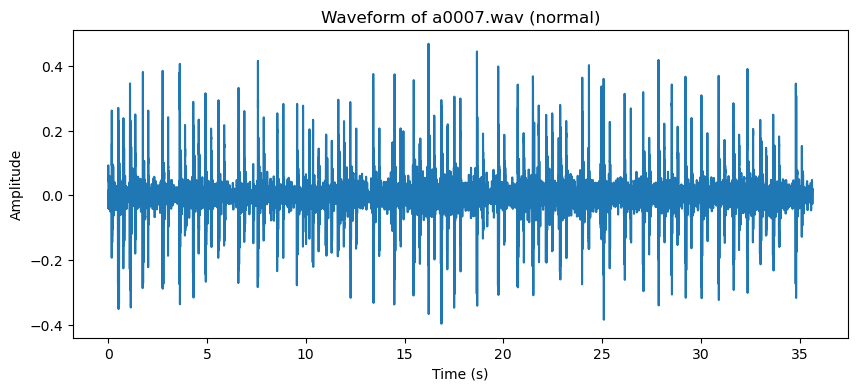

Data [-0.0020752  -0.009552   -0.01977539 ... -0.06793213 -0.08236694
 -0.11697388]
Size of data 16000
Sampling rate 2000


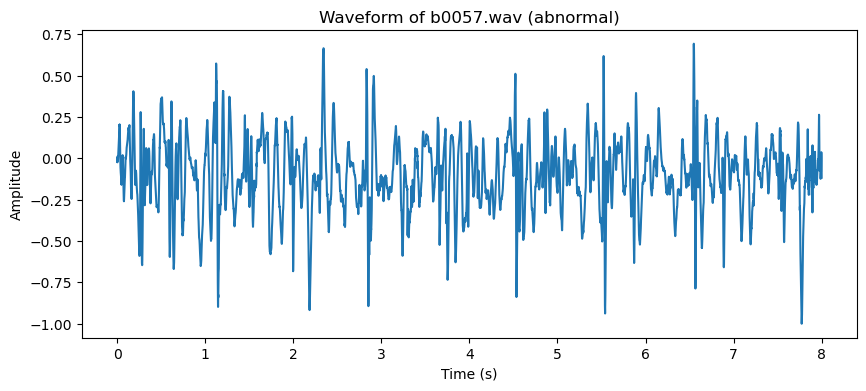

In [2]:
def plot_wav_file(file_name, label, folder_path):
    file_path = os.path.join(folder_path, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File {file_name} not found in {folder_path} folder.")
        return

    data, sample_rate = librosa.load(file_path, sr=None)
    print('Data',data)
    print('Size of data',len(data))
    print('Sampling rate',sample_rate)
    time = np.linspace(0, len(data) / sample_rate, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.title(f"Waveform of {file_name} ({label})")
    plt.plot(time, data)
    plt.ylabel("Amplitude")
    plt.xlabel("Time (s)")
    plt.show()

files_to_plot = {
    "a0007.wav": "normal",
    "b0057.wav": "abnormal"
}


# Define folder paths
normal_folder_path = r'Data Set\Normal'
abnormal_folder_path = r'Data Set\Abnormal'

# Plot each file
for file_name, label in files_to_plot.items():
    if label == "normal":
        plot_wav_file(file_name, label, normal_folder_path)
    elif label == "abnormal":
        plot_wav_file(file_name, label, abnormal_folder_path)



### Displaying MelSpectogram

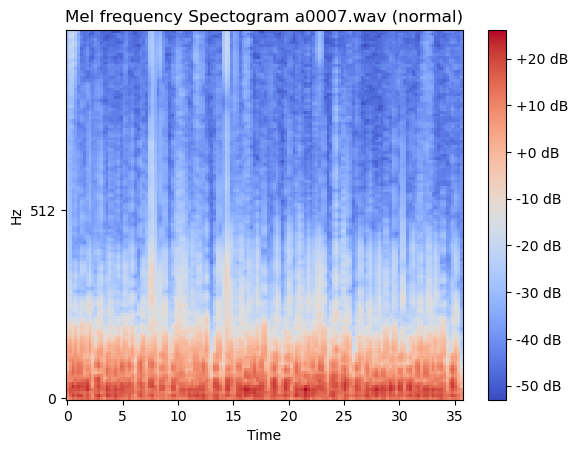

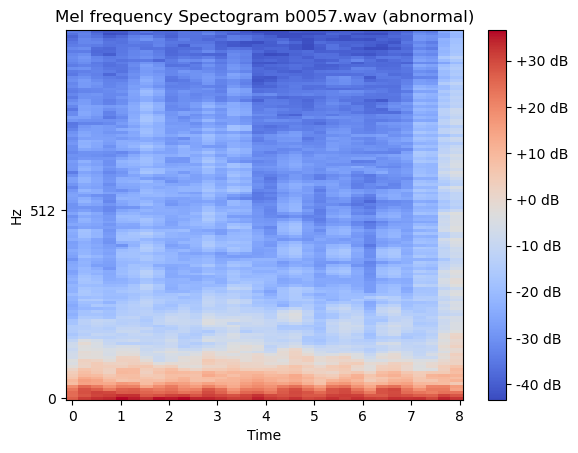

In [3]:
def extract_features_display(file_name, label, folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File {file_name} not found in {folder_path} folder.")
        return
        
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)
    return audio

def displayspectogram(audio,title):
    fig, ax = plt.subplots()
    #Compute a mel-scaled spectrogram.
    mel_spectogram = librosa.feature.melspectrogram(y=audio, sr=2000)
    #Convert a spectrogram to decibel (dB) units.
    log_mel_spectogram = librosa.power_to_db(mel_spectogram)
    img = librosa.display.specshow(log_mel_spectogram,y_axis='mel', x_axis='time',sr=2000)
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    

files_to_plot = {
    "a0007.wav": "normal",
    "b0057.wav": "abnormal",    
}

# Define folder paths
normal_folder_path = r'Data Set\Normal'
abnormal_folder_path = r'Data Set\Abnormal'

# Plot each spectogram
for file_name, label in files_to_plot.items():
    if label == "normal":
        data_red = extract_features_display(file_name, label, normal_folder_path) 
        #Mel Spectogram
        displayspectogram(data_red,f'Mel frequency Spectogram {file_name} ({label})')
    elif label == "abnormal":
        data_red = extract_features_display(file_name, label, abnormal_folder_path) 
        #Mel Spectogram
        displayspectogram(data_red,f'Mel frequency Spectogram {file_name} ({label})')

In [4]:
def extract_features(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)
    return audio

### Calculate Spectrogram data and Corresponding labels

In [5]:
data_dir = r'Data Set'
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        
        #Segmenting data into chucks of 16000 parts 
        data_red = extract_features(audio_path) 
        segmented_data = [data_red[i:i+16000] for i in range(0,len(data_red),16000)]
        
        #Padding will be done on the last segment if length of last segment is less than 16000
        if len(segmented_data[len(segmented_data)-1]) < 16000:
            pad_len = ((16000-len(segmented_data[len(segmented_data)-1]))//2)
            segmented_data_last = np.pad(segmented_data[len(segmented_data)-1], pad_len, 'mean')
            segmented_data[len(segmented_data)-1] = segmented_data_last

        # Calculate mel-spectogram
        for i in range(0,len(segmented_data)):
            mel_spectogram = librosa.feature.melspectrogram(y=segmented_data[i], sr=2000)
            log_mel_spectogram = librosa.power_to_db(mel_spectogram)
            data.append(log_mel_spectogram)
            labels.append(class_labels.index(label))

data = np.asarray(data)
data = data[..., np.newaxis]
labels = np.asarray(labels)

In [6]:
(data.shape,labels.shape)

((4155, 128, 32, 1), (4155,))

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=50,shuffle=True)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3324, 128, 32, 1), (831, 128, 32, 1), (3324,), (831,))

### Approach-1
### CNN Model

In [9]:
model = Sequential()

# Add convolutional layer with 16 3x3 filters, stride 1, and ReLU activation with same padding.
model.add(Conv2D(16, kernel_size=(3,3), strides=(1, 1), activation='relu',input_shape=(128,32,1)))
# Add max pooling layer with 2x2 kernel size and stride 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# Add convolutional layer with 32 3x3 filters, stride 1, and ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
# Add max pooling layer with 3x3 kernel size and stride 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# Flatten the output
model.add(Flatten())

# Add fully connected layer with 10 neurons and ReLU activation
model.add(Dense(10, activation='relu'))

# Add fully connected layer with 2 neurons and softmax activation
model.add(Dense(2, activation='softmax'))

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 30, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        57,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,432 (243.88 KB)

 Trainable params: 62,432 (243.88 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
adam_optimizer = Adam(learning_rate=0.0001) 
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_stft = model.fit(X_train, y_train, batch_size=16, epochs=30)
loss, test_accuracy = model.evaluate(X_test, y_test,verbose=0)

print("Test Accuracy:", test_accuracy)

Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5864 - loss: 0.8059
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6910 - loss: 0.6142
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7356 - loss: 0.5442
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7466 - loss: 0.5251
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7584 - loss: 0.4850
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7868 - loss: 0.4559
Epoch 7/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8094 - loss: 0.4317
Epoch 8/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8127 - loss: 0.4154
Epoch 9/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8384 - loss: 0.3817
Epoch 10/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8491 - loss: 0.3601
Epoch 11/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8542 - loss: 0.3421
Epoch 12/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

### Plotting Training Accuracy and Training Loss

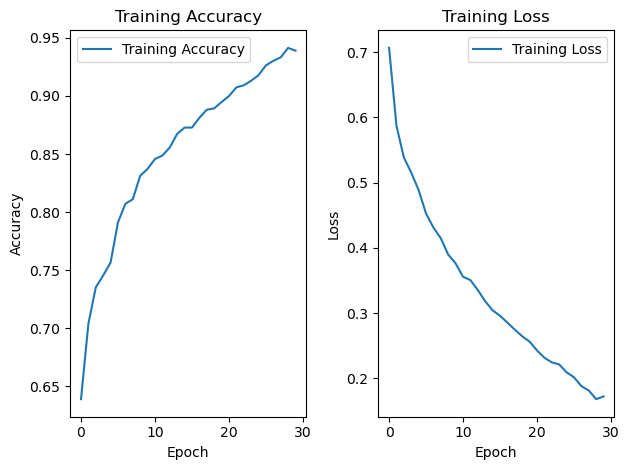

In [11]:
def plot_training(history):
    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training accuracy and loss for the above model
plot_training(history_stft)


### Confusion Matrix

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


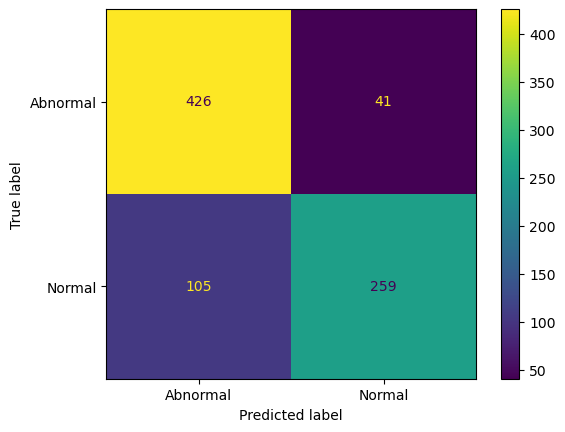

In [12]:
# Predictions on test data
from sklearn import metrics
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)
actual = y_test
predicted = y_pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Abnormal', 'Normal'])

cm_display.plot()
plt.show()


True Positive 259
False Positive 41
True Negative 426
False Negative 105
Sensitivity: 0.7115384615384616
Specificity: 0.9122055674518201
Accuracy: 0.8243080625752106


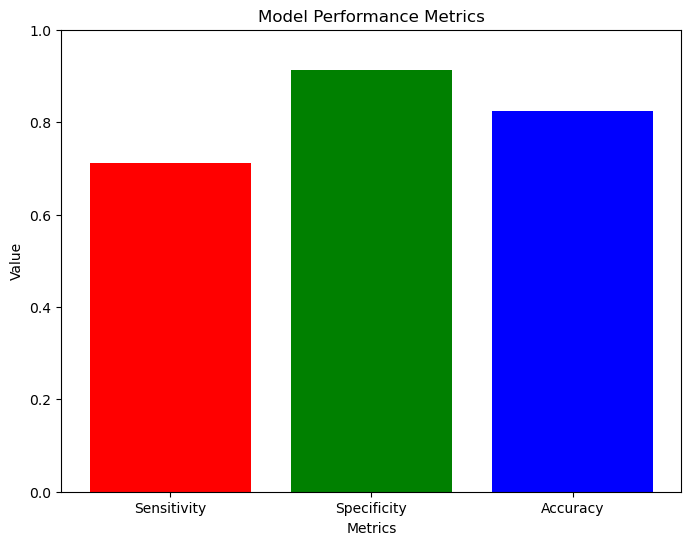

In [13]:
TP = confusion_matrix[1, 1]
FP = confusion_matrix[0, 1]
FN = confusion_matrix[1, 0]
TN = confusion_matrix[0, 0]

# Sensitivity, specificity, accuracy
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("True Positive",TP)
print("False Positive",FP)
print("True Negative",TN)
print("False Negative",FN)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)

metrics = ['Sensitivity', 'Specificity', 'Accuracy']
values = [sensitivity, specificity, accuracy]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['red', 'green', 'blue'])
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.show()

# Approach 2

In [14]:
learning_rate = 1e-5
build_model_1 = tf.keras.Sequential([
     layers.Conv2D(16, (3, 3), strides=(1, 1), activation='relu', input_shape=(128,32,1)),
     layers.MaxPooling2D((2, 2), strides=(2, 2)),
     layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
     layers.MaxPooling2D((2, 2), strides=(2, 2)),
     layers.Flatten(),
     layers.Dense(10, activation='relu'),
     layers.Dense(2, activation='softmax')
])
optimizer = optimizers.Adam(learning_rate=learning_rate)
build_model_1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
build_model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 30, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        57,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,432 (243.88 KB)

 Trainable params: 62,432 (243.88 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Extract features from the second last fully connected layer
feature_extractor_m1 = tf.keras.Model(inputs=build_model_1.inputs, outputs=build_model_1.layers[-2].output)

feature_extractor_m1.summary()

# Predict the features for train and test data
train_features_m1 = feature_extractor_m1.predict(X_train)
test_features_m1 = feature_extractor_m1.predict(X_test)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 32, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 30, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        57,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,410 (243.79 KB)

 Trainable params: 62,410 (243.79 KB)

 Non-trainable params: 0 (0.00 B)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [16]:
learning_rate = 1e-5
build_model_2 = tf.keras.Sequential([
     layers.Conv2D(16, (3, 3), strides=(1, 1), activation='relu', input_shape=(128,32,1)),
     layers.AvgPool2D((2, 2), strides=(2, 2)),
     layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
     layers.AvgPool2D((2, 2), strides=(2, 2)),
     layers.Flatten(),
     layers.Dense(10, activation='relu'),
     layers.Dense(2, activation='softmax')
])
optimizer = optimizers.Adam(learning_rate=learning_rate)
build_model_2.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
build_model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 30, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 63, 15, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 30, 6, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        57,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,432 (243.88 KB)

 Trainable params: 62,432 (243.88 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Extract features from the second last fully connected layer
feature_extractor_m2 = tf.keras.Model(inputs=build_model_2.inputs, outputs=build_model_2.layers[-2].output)

feature_extractor_m2.summary()

# Predict the features for train and test data
train_features_m2 = feature_extractor_m2.predict(X_train)
test_features_m2 = feature_extractor_m2.predict(X_test)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 32, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 126, 30, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 63, 15, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 30, 6, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        57,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,410 (243.79 KB)

 Trainable params: 62,410 (243.79 KB)

 Non-trainable params: 0 (0.00 B)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [18]:
# Extract the deep features from Model-1 and Model-2 and stack the features horizontally

train_stacked_features = np.hstack((train_features_m1, train_features_m2))
test_stacked_features = np.hstack((test_features_m1, test_features_m2))

In [19]:
train_stacked_features.shape,test_stacked_features.shape

((3324, 20), (831, 20))

In [20]:
# Model stacked features using Random Forest classifier
rf_classifier_stack = RandomForestClassifier(n_estimators=100, random_state=50)
rf_classifier_stack.fit(train_stacked_features, y_train)

# Predict using the Random Forest classifier
predictions_m3 = rf_classifier_stack.predict(test_stacked_features)

accuracy_m3 = accuracy_score(y_test, predictions_m3)
print("Accuracy of Random Forest classifier on Stacked Features:", accuracy_m3)

Accuracy of Random Forest classifier on Stacked Features: 0.7557160048134778


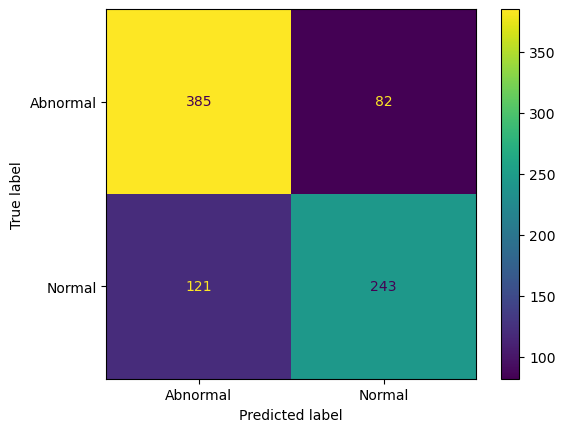

In [21]:
# Predictions on test data
from sklearn import metrics
actual = y_test
predicted = predictions_m3

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Abnormal', 'Normal'])

cm_display.plot()
plt.show()

True Positive 243
False Positive 82
True Negative 385
False Negative 121
Sensitivity: 0.6675824175824175
Specificity: 0.8244111349036403
Accuracy: 0.7557160048134778


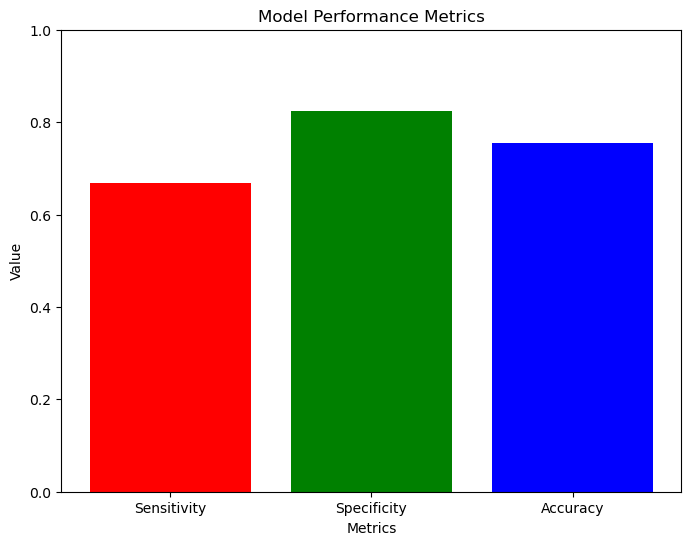

In [22]:
TP = confusion_matrix[1, 1]
FP = confusion_matrix[0, 1]
FN = confusion_matrix[1, 0]
TN = confusion_matrix[0, 0]

# Sensitivity, specificity, accuracy
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("True Positive",TP)
print("False Positive",FP)
print("True Negative",TN)
print("False Negative",FN)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)

metrics = ['Sensitivity', 'Specificity', 'Accuracy']
values = [sensitivity, specificity, accuracy]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['red', 'green', 'blue'])
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.show()